### Initially, the comments were written in Russian. Translated by Google Translator

### Изначально комментарии были написаны на русском языке. Переведены через Google-переводчик

# Tasks:

1. Check whether the passage time of the various stages differs for users who have completed training, from users who have started training, but have not completed it, and from those who have not started training.

2. To see if there is a relationship between the probability of paying for questions and the number of training sessions that the user started or completed.

3. Determine how often users start learning after they have selected a difficulty level.

# Задачи:

1. Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение,  от пользователей начашших обучение, но не закончившим его, и от не начинавших обучение.

2. Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

3. Определить, как часто пользователи начинают обучение после того, как они выбрали уровень сложности. 

In [1]:
# importing the necessary tools
# импортируем необходимые инструменты
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import matplotlib.patches as patches
import warnings; warnings.simplefilter('ignore')

#### We are preparing the necessary data, namely the data of users who registered in 2018

#### Подгатавливаем необходимые данные, а именно данные пользователей зарегистрировавшихся в 2018 году

In [2]:
event=pd.read_csv('C:\\Users\\dgush\\Nbook(pyton)\\7_4_Events (1).csv')
purchase=pd.read_csv("C:\\Users\\dgush\\Nbook(pyton)\\purchase.xls")

In [3]:
# Filtering out all users registered in 2018
# Отфильтровываем всех пользователей зарегистрировавшихся в 2018 году
reg2018 = event[(event['event_type'] == 'registration') & (event['start_time'] >= '2018-01-01') & (event['start_time'] < '2019-01-01')]

#Creating a list of unique user IDs registered in 2018
#Создаём список уникальных ID пользователей зарегестрировашихся в 2018 году
reg2018_user_list = reg2018['user_id'].unique()

# Select from both dataframes all user actions from the list
# Отбираем из обоих dataframe все действия пользователей из списка
events_df = event[event.user_id.isin(reg2018_user_list)]
purchase_df = purchase[purchase.user_id.isin(reg2018_user_list)]

#  Bring the time to the datetime format
# Приводим время к формату datetime
events_df.start_time = pd.to_datetime(events_df.start_time, format = '%Y-%m-%dT%H:%M:%S')
purchase_df.event_datetime = pd.to_datetime(purchase_df.event_datetime, format = '%Y-%m-%dT%H:%M:%S')

# Adjusting the dataframes to merge: create a column "event_type" and rename the rest
# Подгатавливаем датафреймы к объединению: создам колонку "Тип действия" и переименовываем остальные
purchase_df['event_type'] = 'purchase'
purchase_df = purchase_df.rename(columns = {'id':'purchase_id'})
purchase_df = purchase_df.rename(columns = {'event_datetime':'start_time'})
events_df = events_df.rename(columns = {'id':'event_id'})

# Combining data into one dataframe
# Объединяем данные в один датафрейм
total_events_df = pd.concat([events_df,purchase_df],sort = False)

# reset indexes and sort by time of events
# сбрасываем индексы и сортируем по времени действия
total_events_df = total_events_df.reset_index(drop = True).sort_values('start_time')

We will divide all users into three groups (Past, not past, not started tutorial) and add a column with the names of the groups to the table.

Разделим всех пользователей на три группы (Прошедшие, не прошедшие, не начинавшие обучение) и добавим в таблицу столбец с названиями групп.

In [4]:
# Create a list of users who have completed training
# Создадим список пользователей закончивших обучение
tutorial_finish_df = total_events_df[total_events_df['event_type'] == 'tutorial_finish']
set_0 = tutorial_finish_df['user_id'].unique()

# The list is not finished
# Список не закончивших
tutorial_not_df = total_events_df[ - total_events_df.user_id.isin(set_0)]

# And additionally select from it a list of those who started but did not finish the training
# И дополнительно выделим из него список тех кто начинал но не закончил обучение
tutorial_not_fin_tut = tutorial_not_df[tutorial_not_df['event_type'] == 'tutorial_start']
set_1 = tutorial_not_fin_tut.user_id.unique()

# Add a column with a group
# Добавим столбец с группой
total_events_df['group'] = total_events_df.apply(lambda x: 'Прошедшие' if x['user_id'] in set_0 
                                                 else ('Непрошедшие' if x['user_id'] in set_1  
                                                 else 'Не начинавшие'), axis=1)


## We check whether the time of passing different stages differs for different groups

## Проверяем отличается ли время прохождения разных этапов у разных групп

In [5]:
# Leave only the columns necessary for analyzing time intervals
# Оставляем только столбцы нужные для анализа временных промежутков
time_events_df=total_events_df[['user_id','event_type','start_time','group']]

Choose time intervals for comparison: from user registration to the start of training; from registration to the choice of a package of questions; from registration to payment of additional packages; from the choice of free to the payment of additional packages.

Выбираем временные промежутки для сравнения: от регестрации пользователя до начала обучения; от регистрации до выбора пакета вопросов; от регистрации до оплаты дополнительтехных пакетов; от выбора бесплатных до оплаты дополнительнительных пакетов.

In [6]:
# create dataframes for actions (registration, start of training, etc.). Rename the column 'start_time' so as not to get confused in the combined df
# создаём датафреймы по действиям (регистрация, начало обучения и т.д.). Переименовываем столбец 'start_time' , чтоб не запутатся в объеденённом df
reg_time_df = time_events_df[time_events_df['event_type'] == 'registration'].rename(columns = {'start_time':'registration_time'})
tut_start_df = time_events_df[time_events_df['event_type'] == 'tutorial_start'].rename(columns = {'start_time':'tut_start_time'})

# combine the tables and add the timedelta time difference column
# объединяем таблици и добавляем колонку разница во времени timedelta
merge_1_df = reg_time_df.merge(tut_start_df, on = 'user_id', how = 'inner')

# count how much time has passed between actions and translate this time into hours
# считаем сколько прошло времени между действиями и переводим это время в часы
merge_1_df['timedelta_hour'] = (merge_1_df['tut_start_time'] - merge_1_df['registration_time']) / pd.Timedelta('1 hour')
# Агрегируем данные для визуализации
reg_tut_df = merge_1_df[['timedelta_hour','group_x']].groupby('group_x').mean().reset_index()

# Analogy.  Registration - selection of a package of questions
# По аналогии. Регистрация - выбор пакета вопросов
pack_choice_df = time_events_df[time_events_df['event_type'] == 'pack_choice'].rename(columns = {'start_time': 'pack_choice_time'})
merge_2_df = reg_time_df.merge(pack_choice_df, on = 'user_id', how = 'inner')
merge_2_df['timedelta_hour'] = (merge_2_df['pack_choice_time'] - merge_2_df['registration_time']) / pd.Timedelta('1 hour')
reg_pack_df = merge_2_df[['group_x','timedelta_hour']].groupby('group_x').mean().reset_index()

# Registration - purchase of a paid package
# Регистрация - покупка платного пакета
purchase_time_df = time_events_df[time_events_df['event_type'] == 'purchase'].rename(columns = {'start_time': 'purchase_time'})
merge_3_df = reg_time_df.merge(purchase_time_df, on = 'user_id',how = 'inner')
merge_3_df['timedelta_hour'] = (merge_3_df['purchase_time'] - merge_3_df['registration_time']) / pd.Timedelta('1 hour')
reg_pur_df = merge_3_df[['group_x','timedelta_hour']].groupby('group_x').mean().reset_index()

# Choosing a free one - buying a paid package
# Выбор бесплатного - покупка пллатного пакета
merge_4_df = pack_choice_df.merge(purchase_time_df, on = 'user_id',how = 'inner')
merge_4_df['timedelta_hour'] = (merge_4_df['purchase_time'] - merge_4_df['pack_choice_time']) / pd.Timedelta('1 hour')
pchoice_pur_df = merge_4_df[['group_x','timedelta_hour']].groupby('group_x').mean().reset_index()

For clarity, we make simple histograms

Для наглядности делаем простые гистограммы


От регистрации до начала обучения:        group_x  timedelta_hour
0  Непрошедшие        5.444504
1    Прошедшие        5.327487 

 От регистрации до выбора темы          group_x  timedelta_hour
0  Не начинавшие        5.121160
1    Непрошедшие        8.375664
2      Прошедшие        7.176572 

 От регистрации до оплаты          group_x  timedelta_hour
0  Не начинавшие      105.100530
1    Непрошедшие      101.548115
2      Прошедшие       96.500902 

 От выбора темы до оплаты          group_x  timedelta_hour
0  Не начинавшие      100.825997
1    Непрошедшие       93.246363
2      Прошедшие       89.299900


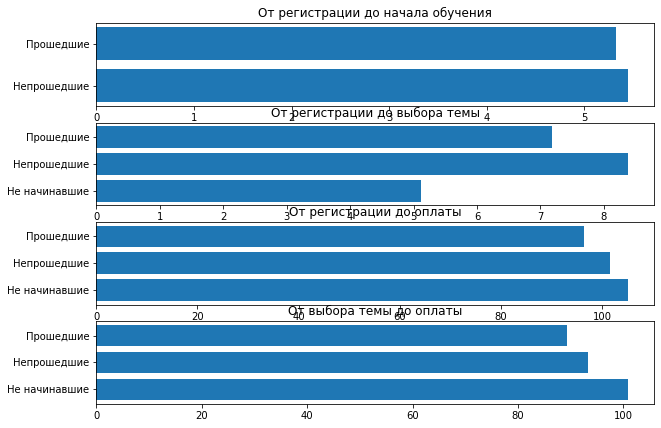

In [7]:
fig, axes = plt.subplots(4, 1, figsize = (10, 7))

axes[0].barh(reg_tut_df['group_x'],reg_tut_df['timedelta_hour'])
axes[0].set_title('От регистрации до начала обучения')

axes[1].barh(reg_pack_df['group_x'],reg_pack_df['timedelta_hour'])
axes[1].set_title('От регистрации до выбора темы')

axes[2].barh(reg_pur_df['group_x'],reg_pur_df['timedelta_hour'])
axes[2].set_title('От регистрации до оплаты')

axes[3].barh(pchoice_pur_df['group_x'],pchoice_pur_df['timedelta_hour'])
axes[3].set_title('От выбора темы до оплаты')

print('От регистрации до начала обучения:',reg_tut_df,
      '\n\n','От регистрации до выбора темы', reg_pack_df,
      '\n\n','От регистрации до оплаты',reg_pur_df,
      '\n\n','От выбора темы до оплаты', pchoice_pur_df)

Conclusion:
From the data provided, it can be seen that users who have completed training spend less time at the transition stage from choosing a free package of questions to buying a paid one. And also trained users (despite the fact that they spent time on training) pass faster from registration to the purchase of additional questions than users who have not been trained.

Вывод:
Из предоставленых данных видно, что пользователи прошедшие обучение тратят меньше времени на этапе перехода от выбора бесплатного пакета вопросов до покупки платного. А так же прошедшие обучение пользователи (несмотря на то, что потратили время на обучение) быстрее проходят от регестрации до покупки дополнительных вопросов, чем пользователи не прошедшие обучение.

##  Checking whether there is a relationship between the probability of paying for questions and the number of training sessions.

## Проверяем, существует ли зависимость между вероятностью оплаты вопросов и количеством прохождений обучения. 

Let's calculate how often the user started training and whether this affects the probability of buying additional questions for them.

Посчитаем как часто пользователь начинал обучение и влияет ли это на вероятность покупки им дополнительных вопросов.

In [8]:
# Counting the number of training sessions started for each user
# Считаем количество начатых обучений для каждого пользователя
tutorial_start_count_df =  total_events_df[total_events_df['event_type'] == 'tutorial_start'].groupby(['user_id'])['start_time'].count().reset_index()

# Renaming the column
# Переименовываем столбец
tutorial_start_count_df = tutorial_start_count_df.rename(columns = {'start_time':'tutorial_count'})

# Adding a new column to the table by combining dataframes
# Добавляем новый столбец к таблице объединяя датафреймы
count_tutorial_group_df = total_events_df.merge(tutorial_start_count_df, how = 'outer', on = 'user_id')

# Replace the NaN with zeros
# Заменяем пропуски нулями
count_tutorial_group_df['tutorial_count'] = count_tutorial_group_df['tutorial_count'].fillna(0)

In [9]:
# Grouping data on the number of training sessions
# Групперуем данные по количеству прохождений обучения
conv_df = count_tutorial_group_df.groupby('tutorial_count').agg({'user_id': 'count','purchase_id': 'count'}).reset_index()

# Adding a column with the conversion rate of users to buyers
# Добовляем колонку с кофициентом конверсии пользователей в покупателей
conv_df['conv'] = round((conv_df['purchase_id'] / conv_df['user_id']) * 100, 1)

Text(0.5, 0, 'Количество обучений')

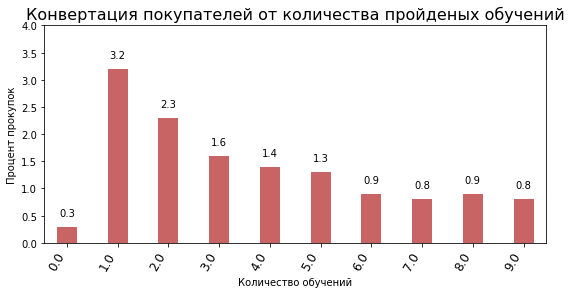

In [10]:
# Creating a histogram of the dependence of the number of exposures and the probability of buying additional questions
# Создаём гистограмму зависимости количество обоучений и вероятность покупки дополнительных вопросов
fig, ax = plt.subplots(figsize=(9,4))
ax.vlines(x=conv_df.tutorial_count, ymin=0, ymax=conv_df.conv, color='firebrick', alpha=0.7, linewidth=20)

# Data on the histogram
# Данные на графике
for i, conv in enumerate(conv_df.conv):
    ax.text(i, conv+0.2, conv, horizontalalignment='center')


# Title, Label, Ticks and Ylim
# Подписи, названия, стиль текста
ax.set_title('Конвертация покупателей от количества пройденых обучений', fontdict={'size':16})
ax.set(ylabel='Процент прокупок', ylim=(0, 4))
plt.xticks(conv_df.index, conv_df.tutorial_count, rotation=60, horizontalalignment='right', fontsize=12)
plt.xlabel('Количество обучений')


Conclusion:

There is a clear correlation between the number of studies started and the purchase of additional question packages. Most often, questions are bought by users who have been trained 1 time, 3.2% of the total. Of those who have been trained twice, the percentage of purchases is already 2.3. And further, with an increase in the number of training sessions, the percentage of those who paid for the pocket decreases below one percent
At the same time, only 0.3% of users who have not started training pay an additional fee. questions.

Perhaps this is due to the initially higher motivation of people. Users from the first group are trained more carefully, which allows them not to contact him anymore, and are more interested in getting new interesting questions.

 Вывод:

Чётко просматривается корреляция между количеством начатых обучений и покупкой дополнительных пакетов вопросов. Чаще всего вопросы покупают пользователи прошедшие обучение 1 раз, 3.2% от общего количества. Из тех, кто прошёл обучение дважды процент покупок уже 2.3. И далее, с увеличением количества прохождений обучения процент оплативших покет снижается ниже одного процента
При этом лишь 0.3% из пользователей не начинавших обучение оплачивают доп. вопросы.

Возможно, это связано с изначально более высокой мотивации людей. Пользователи из первой группы более внимательно проходят обучение, что позволяет больше не обращаться к нему, и больше заинтересованы в получении новых интересных вопросов.

## How often do users start learning after they have started the game.

## Часто ли пользователи начинают обучение после того, как они начали игру.

We will divide users into two groups, those who returned to training after the start of the game and those who did not return.

Разделим пользователей на две группы, те кто возвращался к обучению после начала игры и невозвращавшихся.

In [11]:
# writing a group function that will mark users who have started training after choosing the difficulty level
# пишем функцию group которая пометит пользователей начавших обучение после выбора уровня сложности
def group(x):  
    if x.pack_choice_time > x.tut_start_time:
        return 'return_tutorial'
    else:
        return 'tutorial'

In [12]:
# Creating a dataframe in which we leave the user id and the time of their registration and the start of the game (choosing a package of questions)
# Создаём датафрейм в котором оставляем id пользователя и время их регистрации и начала игры (выбора пакета вопросов)
tut_choice_time_df = tut_start_df[['user_id','tut_start_time']].merge(pack_choice_df[['user_id','pack_choice_time']], how = 'inner', on = 'user_id')

# Using the group function, we divide users into groups
# С помощью функции group разделяем пользователей на группы
tut_choice_time_df['tutorial_group'] = tut_choice_time_df.apply(lambda x: group(x), axis = 1)

# Creating a dataframe with the number of users in each group
# Создаём датафрейм с количеством пользователей в каждой группе
return_tut_df = tut_choice_time_df['tutorial_group'].value_counts().reset_index()

In [13]:
# Count the percentage of users in each group
# Считаем процент пользователей в каждой группе
return_tut_df['percent'] = round((return_tut_df['tutorial_group'] / return_tut_df['tutorial_group'].sum()) * 100)


In [14]:
# For the convenience of plotting, we return the indexes and create a text graph with the names of the segments
# Для удобства составления графика возвращаем индексы и создаём текстовую графу с названиями сегментов
return_tut_df.set_index('index', inplace = True)
return_tut_df['txt'] = return_tut_df['percent'].astype(str) + ' %'

Text(0, 0.5, '')

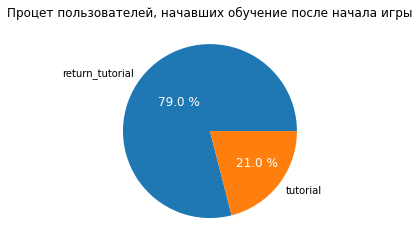

In [15]:
# Creating a visual graph
# Создаём наглядный график 
return_tut_df['percent'].plot(kind='pie')

plt.title("Процет пользователей, начавших обучение после начала игры")
plt.text(-0.6,0.3,return_tut_df['txt'].iloc[0] , color = 'w', size = 12)
plt.text(0.3, -0.4,return_tut_df['txt'].iloc[1], color = 'w', size = 12)
plt.ylabel("")


Conclusion:

As can be seen from the graph, in 79% of cases, users return to training after the start of the game. 
From this we can conclude that the interface of the game is not simple and clear enough, and as a result needs to be improved

Вывод:

Как видно из графика, в 79% случаев пользователи возвращаются к обучению после начала игры. 
Из этого можно сделать вывод, что интерфейс игры не достаточно прост и понятен, и как следствие нуждается в доработке